In [1]:
# install java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# install spark (change the version number if needed)
!wget -q https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
# unzip the spark file to the current folder
!tar xf spark-3.5.5-bin-hadoop3.tgz

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,704 kB]
Get:13 https://r2u.stat.illinois.edu/u

In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [2]:
import os
print(os.environ["SPARK_HOME"])

/content/spark-3.5.5-bin-hadoop3


In [3]:
!pip install findspark

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Anime Recommendations") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

In [6]:
df = spark.read.csv("users-score-2023_prep.csv", header=True, inferSchema=True)

In [7]:
df.dtypes

[('user_id', 'int'), ('anime_id', 'int'), ('rating', 'double')]

In [8]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType, IntegerType

df = df.withColumn("rating", col("rating").cast(IntegerType()))
df.dtypes

[('user_id', 'int'), ('anime_id', 'int'), ('rating', 'int')]

In [9]:
df.show()

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      9|     777|     4|
|     20|    1519|     9|
|     20|     121|    10|
|     20|    5365|     6|
|     23|    5355|     6|
|     47|      32|     7|
|     47|      24|     9|
|     48|    3342|     7|
|     48|     329|     7|
|     70|    3594|     6|
|     80|     121|    10|
|     81|   28497|     7|
|     88|   48569|    10|
|     88|   20583|     9|
|    110|   22535|     9|
|    110|     585|     7|
|    110|     164|     6|
|    119|     300|     7|
|    119|   11703|     7|
|    120|     132|     9|
+-------+--------+------+
only showing top 20 rows



In [14]:
df.persist()

DataFrame[user_id: int, anime_id: int, rating: int]

In [10]:
from pyspark.sql.functions import isnan, col

# Remove both null and NaN values
cleaned_df = df.filter(
    df.rating.isNotNull() &
    ~isnan(col("rating"))
)

In [ ]:
# Verify the clean dataset
print(f"Original count: {df.count()}")
print(f"Cleaned count: {cleaned_df.count()}")

In [11]:
final_df = cleaned_df.select("user_id", "anime_id", "rating")
final_df.show()

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      9|     777|     4|
|     20|    1519|     9|
|     20|     121|    10|
|     20|    5365|     6|
|     23|    5355|     6|
|     47|      32|     7|
|     47|      24|     9|
|     48|    3342|     7|
|     48|     329|     7|
|     70|    3594|     6|
|     80|     121|    10|
|     81|   28497|     7|
|     88|   48569|    10|
|     88|   20583|     9|
|    110|   22535|     9|
|    110|     585|     7|
|    110|     164|     6|
|    119|     300|     7|
|    119|   11703|     7|
|    120|     132|     9|
+-------+--------+------+
only showing top 20 rows



In [12]:
final_df.persist()

DataFrame[user_id: int, anime_id: int, rating: int]

In [13]:
(train_df, val_df,test_df) = final_df.randomSplit([0.7, 0.05, 0.25], seed=42)


Check Basic Split Sizes

In [14]:
print(f"Train count: {train_df.count()}")
print(f"Validation count: {val_df.count()}")
print(f"Test count: {test_df.count()}")


Train count: 17027430
Validation count: 1214808
Test count: 6079826


In [18]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


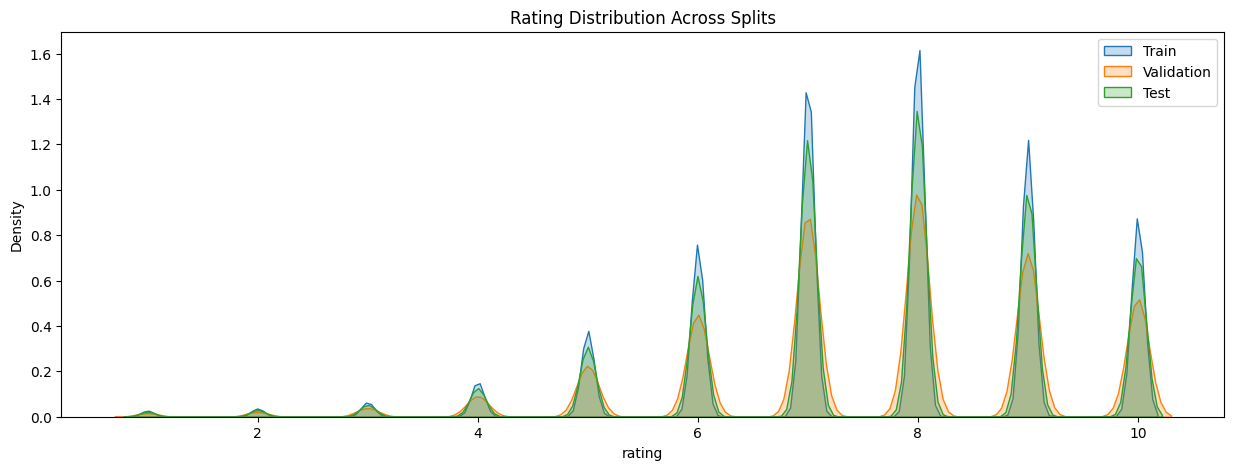

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

train_ratings = train_df.select('rating').toPandas()
val_ratings = val_df.select('rating').toPandas()
test_ratings = test_df.select('rating').toPandas()

plt.figure(figsize=(15, 5))

sns.kdeplot(train_ratings['rating'], label='Train', fill=True)
sns.kdeplot(val_ratings['rating'], label='Validation', fill=True)
sns.kdeplot(test_ratings['rating'], label='Test', fill=True)

plt.title('Rating Distribution Across Splits')
plt.legend()
plt.show()


From the visualization: It can be concluded that  
Similar Shape:
The Train, Validation, and Test curves almost perfectly overlap each other.

Same Peaks:
All splits peak at similar rating values (around 6, 7, 8, 9, 10),
which means that the important ratings (frequent scores) are preserved across splits.

No Major Skew:
There's no one split that is heavily biased toward a low or high rating compared to the others.

Balanced Low and High Ratings:
Even the less frequent ratings (like 1-3) are still present across all three datasets.